# CNN intro

X_train.shape=(50000, 32, 32, 3), X_test.shape=(10000, 32, 32, 3)
y_train.shape=(50000,), y_test.shape=(10000,)


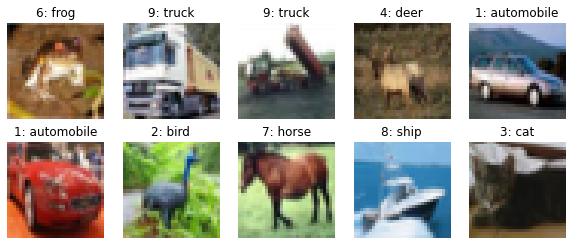

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()
print(f"{X_train.shape=}, {X_test.shape=}")
y_train, y_test = y_train.ravel(), y_test.ravel()
print(f"{y_train.shape=}, {y_test.shape=}")

labels = ["airplane",
          "automobile",
          "bird",
          "cat",
          "deer",
          "dog",
          "frog",
          "horse",
          "ship",
          "truck"]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f"{y_train[i]}: {labels[y_train[i]]}")
    ax.axis("off")


In [15]:
scaled_X_train = X_train.astype("float32")/255
scaled_X_test = X_test.astype("float32")/255

---
## CNN model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam


def CNN_model(learning_rate=.001, drop_rate=.5, kernels=[32, 64]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    # the convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size=(
            3, 3), activation="relu", kernel_initializer="he_normal",
            input_shape=X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model()
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0 

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

model.fit(
    scaled_X_train, 
    y_train, 
    epochs = 100, 
    callbacks = [early_stopper],
    validation_split = 1/5
)


Epoch 1/100
1250/1250 [==============================] - 30s 8ms/step - loss: 1.5360 - acc: 0.4453 - val_loss: 1.2075 - val_acc: 0.5800
Epoch 2/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2110 - acc: 0.5676 - val_loss: 1.0703 - val_acc: 0.6319
Epoch 3/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0742 - acc: 0.6218 - val_loss: 0.9871 - val_acc: 0.6597
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9669 - acc: 0.6571 - val_loss: 0.9250 - val_acc: 0.6792
Epoch 5/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8860 - acc: 0.6906 - val_loss: 0.9122 - val_acc: 0.6881
Epoch 6/100
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8199 - acc: 0.7132 - val_loss: 0.8807 - val_acc: 0.6925
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7583 - acc: 0.7332 - val_loss: 0.8378 - val_acc: 0.7087
Epoch 8/100
1250/1250 [=========================

In [26]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)

In [ ]:
metrics = pd.DataFrame(model.history.history)


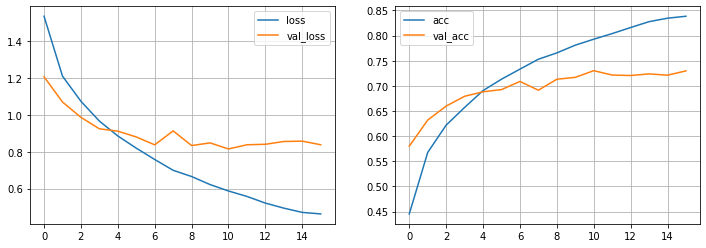

In [27]:
plot_metrics(metrics)

---
## Hyperparameter tuning

In [28]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        scaled_X_train,
        y_train,
        validation_split = 1/5,
        epochs = 6,
    )

    metrics = pd.DataFrame(model.history.history)
    val_acc = metrics["val_acc"].iloc[-1]
    return val_acc


In [29]:
dropout_acc = {}

for drop_rate in np.arange(.1, .6, .1):
    drop_rate = np.round(drop_rate,1)
    dropout_acc[drop_rate] = evaluate_model(drop_rate = drop_rate)

Epoch 1/6
1250/1250 [==============================] - 11s 8ms/step - loss: 1.4137 - acc: 0.4899 - val_loss: 1.2943 - val_acc: 0.5512
Epoch 2/6
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0557 - acc: 0.6297 - val_loss: 1.0130 - val_acc: 0.6440
Epoch 3/6
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8776 - acc: 0.6940 - val_loss: 0.9475 - val_acc: 0.6769
Epoch 4/6
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7426 - acc: 0.7409 - val_loss: 0.8715 - val_acc: 0.7029
Epoch 5/6
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6190 - acc: 0.7835 - val_loss: 0.8732 - val_acc: 0.7113
Epoch 6/6
1250/1250 [==============================] - 9s 7ms/step - loss: 0.5086 - acc: 0.8221 - val_loss: 0.9072 - val_acc: 0.7109
Epoch 1/6
1250/1250 [==============================] - 11s 8ms/step - loss: 1.4133 - acc: 0.4935 - val_loss: 1.1804 - val_acc: 0.5827
Epoch 2/6
1250/1250 [==============================] - 9s 7ms/s

<AxesSubplot:xlabel='Dropouts', ylabel='Validation acc'>

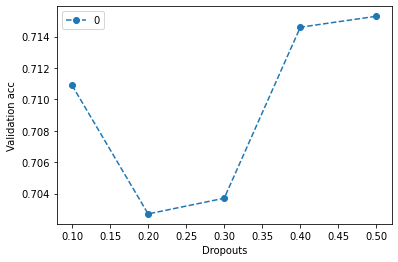

In [30]:
pd.DataFrame(dropout_acc.values(), index=dropout_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")


## When finished
- train on all training data (train and validation) with the tuned parameters
- evaluate on testing data